# **Proyecto 2: Análisis de mercado inmobiliario**

## **Consigna**

En este proyecto profundizarás lo desarrollado en el proyecto 01. El objetivo es aplicar las técnicas incorporadas (Transformación de Datos, Optimización de Hiperparámetros, Modelos Avanzados, etc.) para generar un modelo que tenga un mejor desempeño que el modelo generado en el proyecto anterior. Luego, interpreta ese modelo para responder la siguiente pregunta: ¿qué podemos aprender de nuestro problema estudiando el modelo que generamos?

El trabajo se organiza en tres partes:

### **PARTE A - Transformación de Datos**

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Justifica e implementa:

1. Detección y eliminación de Outliers
1. Encoding
1. Imputación de valores faltantes
1. Escalado de datos
1. Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).

Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - y evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Sea cual sea la respuesta, intenta explicar a qué se debe.

### **PARTE B - Modelos Avanzados**

1. Elige dos de los modelos avanzados vistos (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.
1. Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.
1. Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

### **PARTE C - Interpretación de modelos**

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

* ¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?
* ¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?

### **DESAFÍO OPCIONAL**

Aplica una técnica de Clustering sobre el dataset. Puedes combinar con técnicas de reducción de dimensionalidad para facilitar la visualización. ¿Qué clusters encuentras? ¿A qué pueden corresponder? Te dejamos preguntas que pueden servir como disparadoras: ¿qué barrios se parecen más entre sí?¿qué tipos de propiedades se parecen más entre sí?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

from dstools.eda import DataHandler
from dstools.modeling import RegressionModeling

from sklearn.cluster import KMeans

En primer lugar se mostrarán los resultados de la parte 1 del proyecto.

In [2]:
properati = pd.read_csv('DS_Proyecto_02_Datos_Properati.csv')
data_handler = DataHandler(properati)
regression_modeling = RegressionModeling()

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 88274.0169560616
Raíz del error cuadrático medio en Test: 101609.9322862421



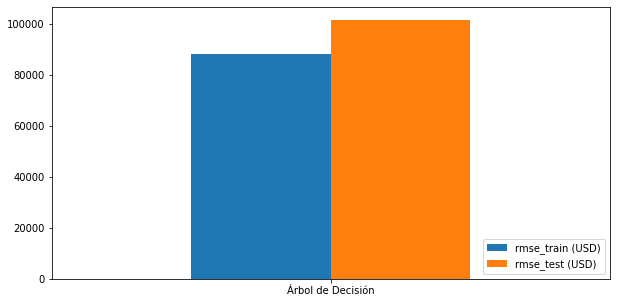

In [3]:
filters = {
    'reset_data': True,
    'fixed_values': {
        'property_type': ['Departamento', 'PH', 'Casa'],
        'l2': ['Capital Federal']
    },
    'columns': ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'property_type', 'price'],
    'max_surface_total' : 1000,
    'min_surface_total' : 15,
    'max_lat': 60,
    'drop_invalid': True,
    'drop_missing': True,
    'max_price' : 4000000
}
data_handler.filter_data(**filters)
dataset = data_handler.processed_data.copy()

labelencoder = LabelEncoder()
dataset.property_type = labelencoder.fit_transform(dataset.property_type)
property_type_dummies = pd.get_dummies(dataset.property_type)
property_type_dummies.columns = labelencoder.classes_

dataset['Departamento'] = property_type_dummies['Departamento']
dataset.drop(['property_type'], axis=1, inplace=True)

dataset = dataset[dataset.bedrooms != 0]
dataset['bath_bed_ratio'] = dataset.bathrooms / dataset.bedrooms
dataset = dataset.drop(['bedrooms', 'bathrooms'], axis=1)

dataset = dataset.drop(['surface_total', 'rooms'], axis=1)

X = dataset.drop(['price'], axis=1)
y = dataset.price

models_info = { 'Árbol de Decisión': DecisionTreeRegressor(random_state=42, max_depth=9) }

regression_modeling.study_dataset(X, y, models_info, metric='rmse', plot_residuals=False, kde=False, plot_error_metrics=True)

regression_modeling.set_benchmark('Árbol de Decisión', print_errors=False)

# Suposiciones iniciales

Seguiremos el mismo punto de partida que en la parte 1:

* **Región a analizar:** Capital Federal.
* **Tipo de propiedades:** Departamento, PH y Casa.

## Parte A - Transformación de datos

Establecemos la semilla a usar en los pasos que dependan de un proceso aleatorio.

In [4]:
random_state = 2020-10-14

Reiniciamos el dataset, filtramos por tipo de propiedad y descartamos los siguientes campos:

* **Fechas:** no se medirán influencias temporales en los precios de los inmuebles.
* **l1, currency y operation_type:** son campos con varianza cero a lo largo del dataset.
* **l2:** l2 y l3 pueden ser descartadas puesto que los campos de latitud y longitud contienen dicha información, sin embargo, l3 no se descarta en esta instancia para poder hacer un breve análisis de datos para lo que puede ser de utilidad.
* **title y description:** no se hará uso de técnicas de NLP para obtener insights de los campos de texto.

In [5]:
filters = {
    'reset_data': True,
    'fixed_values': {
        'property_type': ['Departamento', 'PH', 'Casa'],
        'l2': ['Capital Federal']
    },
    'columns': ['lat', 'lon', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'property_type', 'price'],
}
data_handler.filter_data(**filters)
dataset = data_handler.processed_data.copy()
dataset.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price
0,-34.605880,-58.384949,San Cristobal,7.0,7.0,2.0,140.0,140.0,Departamento,153000.0
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,PH,159000.0
2,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,PH,125000.0
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,PH,295000.0
5,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,PH,150000.0


### Validación en la consistencia de los valores

Luego de filtrado el dataset validaremos la consistencia de los datos.

Se eliminan los registros donde el número de habitaciones es mayor que el de ambientes:

In [6]:
print(f"Size before filtering: {dataset.shape}")
print(f"Invalid instances: {dataset.query('rooms < bedrooms').shape[0]}")
dataset.query('rooms >= bedrooms', inplace=True)
print(f"Size after filtering: {dataset.shape}")

Size before filtering: (91485, 10)
Invalid instances: 63
Size after filtering: (91422, 10)


Ahora se eliminan los campos cuya superficie total sea menor que la cubierta:

In [7]:
print(f"Size before filtering: {dataset.shape}")
print(f"Invalid instances: {dataset.query('surface_total < surface_covered').shape[0]}")
dataset.query('surface_total >= surface_covered', inplace=True)
print(f"Size after filtering: {dataset.shape}")

Size before filtering: (91422, 10)
Invalid instances: 759
Size after filtering: (81230, 10)


### Análisis de valores faltantes

Verificamos la cantidad de valores faltantes en el dataset:

In [8]:
missing_values_count = pd.DataFrame(dataset.isna().sum(), columns=['count_'])
missing_values_count['percentage'] = np.round(100 * missing_values_count.count_ / dataset.shape[0],2)
missing_values_count

,count_,percentage
lat,4241,5.22
lon,4241,5.22
l3,0,0.00
rooms,0,0.00
bedrooms,0,0.00
bathrooms,833,1.03
surface_total,0,0.00
surface_covered,0,0.00
property_type,0,0.00
price,0,0.00


Para este estado del proyecto, no realizaremos imputación de valores por lo que procedemos a eliminar los registros con valores faltantes.

In [9]:
dataset.dropna(inplace=True)
dataset.shape

(76163, 10)

### Análisis de correlación

Generaremos una matriz de correlación para validar variables que puedan ser linealmente dependientes.

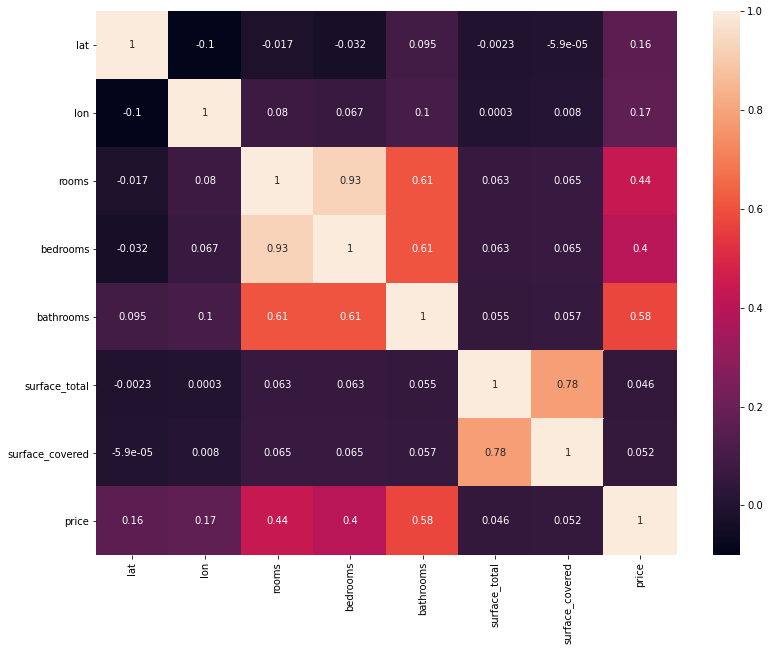

In [10]:
plt.figure(figsize=(13,10))
sns.heatmap(dataset.corr(), annot=True)
plt.show()

Podemos ver que los campos de habitaciones, ambientes, baños y ambos tipos de superficies están altamente correlacionadas. Para algoritmos como Lasso (que se usará posteriormente), esto puede ser un problema. Esto lo resolveremos mediante el uso de la técnica de PCA.

### Detección y eliminación de valores atípicos

Dos metodos en particular se usarán en este análisis: rango intercuartil y 3 sigmas.
Primero haremos un análisis de las cantidades de registros que resultarían clasificadas como outliers usando ambos criterios.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def detect_outliers(data, criteria='3sigma'):
    if criteria=='3sigma':
        data_mean = data.describe().loc['mean']
        data_std = data.describe().loc['std']
        criteria_max = data_mean + 3 * data_std
        criteria_min = data_mean - 3 * data_std
        return (data < criteria_min) | (data > criteria_max)
    if criteria=='iqr':
        q1 = np.quantile(data, 0.25)
        q3 = np.quantile(data, 0.75)
        iqr = q3 - q1
        return (data < q1 - iqr) | (data > q3 + iqr)

dataset_means = dataset.describe().loc['mean']
numeric_columns = dataset_means.index.values
outliers_in_dataset = pd.DataFrame(columns=['% IQR', '% sigmas'], index=numeric_columns)

for column in numeric_columns:
    outliers_3sigma = detect_outliers(dataset[column], criteria='3sigma')
    outliers_iqr = detect_outliers(dataset[column], criteria='iqr')
    
    iqr_number = np.round(100*outliers_iqr.sum()/dataset.shape[0], 2)
    sigma_number = np.round(100*outliers_3sigma.sum()/dataset.shape[0], 2)
    outliers_in_dataset.loc[column] = [iqr_number, sigma_number]

print(outliers_in_dataset)

                 % IQR % sigmas
lat               8.02     0.47
lon               5.07        0
rooms             1.53     1.53
bedrooms          0.66     0.66
bathrooms         3.28      0.9
surface_total    10.63     0.15
surface_covered  10.59      0.1
price            10.75     1.75


Estudiemos el caso de la superficie total para encontrar el motivo de la diferencia.

In [12]:
def compare_outlier_detection_for(column_name):
    print(f'======== {column_name} ========')
    outliers_summary = pd.DataFrame()

    outliers_3sigma_surface_total = detect_outliers(dataset[column_name], criteria='3sigma')
    outliers_summary['sigma'] = dataset[~outliers_3sigma_surface_total][column_name].describe()

    outliers_iqr_surface_total = detect_outliers(dataset[column_name], criteria='iqr')
    outliers_summary['iqr'] = dataset[~outliers_iqr_surface_total][column_name].describe()

    print(outliers_summary.loc[['max', 'min'], :], "\n")

In [13]:
for column in numeric_columns:
    compare_outlier_detection_for(column)

======== lat ========
         sigma        iqr
max -34.535909 -34.556087
min -34.668021 -34.640103 

======== lon ========
         sigma        iqr
max -58.353930 -58.362251
min -58.530468 -58.504268 

======== rooms ========
     sigma  iqr
max    6.0  6.0
min    1.0  1.0 

======== bedrooms ========
     sigma  iqr
max    5.0  5.0
min    0.0  0.0 

======== bathrooms ========
     sigma  iqr
max    4.0  3.0
min    1.0  1.0 

======== surface_total ========
      sigma    iqr
max  3070.0  171.0
min    13.0   13.0 

======== surface_covered ========
      sigma    iqr
max  1400.0  146.0
min     1.0    1.0 

======== price ========
         sigma       iqr
max  1230000.0  431000.0
min     6000.0    6000.0 



Podemos notar lo siguiente:

* Los campos con valores no consistentes con la realidad son: baños, superficie total y superficie cubierta.

* El criterio IQR muestra valores máximos que están por debajo de lo que se ve en la realidad, por ejemplo, hay fácilmente casas que superan los 170 m2. Deducimos que este criterio es muy agresivo en cuanto a la eliminación de registros.

* El criterio de los 3 sigmas no elimina tantos registros (~0.2%), sin embargo, vemos que existen valores límites alejados de la realidad:
    
    * Existen registros con ningun baño. Por el tipo de inmuebles considerados en el análisis, deben tener al menos uno. Por ende se aplicará un filtrado `bathrooms > 0`.
    * Para las superficies totales y cubiertas:

        * El valor de máximo de 3.070 $m^{2}$ puede ser muy alto. Una búsqueda rápida en [Argenprop](https://www.argenprop.com/casa-venta-localidad-capital-federal-desde-1000-m2) se puede notar que para inmuebles de más de 1.000m2, se tienen más de 6 habitaciones y precios cercanos a los 2.000.000 USD. Esto contradice los datos con los que contamos. Se aplicará un filtrado `surface_total <= 1000`.
        * El valor mínimo de superficie de un [microdepartamento](https://www.infobae.com/tendencias/2018/10/09/micro-departamentos-adios-al-bidet-y-a-la-banera-en-las-viviendas-minimas-que-llegan-a-la-ciudad/) es de 18 $m^{2}$, considerandose este razonable. Otro filtro a agregar sería `surface_covered >= 18`.
        * Para los microdepartamentos mencionados en el punto anterior, también se puede apreciar que el precio [esta a partir de los 39.000 USD](https://www.cronista.com/negocios/Microdepartamentos-el-sueno-de-la-casa-propia-desde-us-50.000-20170325-0002.html) (tomando el precio de referencia de Liniers). Es necesaria la condicion `price >= 39000`.

El criterio escogido para usar será el de las 3 sigmas. Posteriormente, se haremos el filtrado mencionado en puntos anteriores.

In [14]:
print(f'Shape before processing {dataset.shape}')

# Eliminating outliers
for column in numeric_columns:
    columns_to_keep = ~detect_outliers(dataset[column], criteria='3sigma')
    dataset = dataset[columns_to_keep].copy()
    
print(f'Shape after processing {dataset.shape}')

Shape before processing (76163, 10)
Shape after processing (69683, 10)


In [15]:
print(f"Dimension antes: {dataset.shape}")
print(f"Registros invalidos: {dataset.query('surface_covered < 18 | surface_total > 1000 | bathrooms == 0 | price < 39000').shape[0]}")
dataset.query('surface_covered >= 18 & surface_total <= 1000 & bathrooms > 0 & price >= 39000', inplace=True)
print(f"Dimension despues: {dataset.shape}")

Dimension antes: (69683, 10)
Registros invalidos: 138
Dimension despues: (69545, 10)


In [16]:
dataset.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,PH,159000.0
2,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,PH,125000.0
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,PH,295000.0
5,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,PH,150000.0
6,-34.600988,-58.433061,Villa Crespo,2.0,1.0,1.0,70.0,70.0,PH,159500.0


### Encoding

Luego de la limpieza de los datos, empezamos con el proceso de codificación del tipo de propiedad.

In [17]:
from sklearn.preprocessing import LabelEncoder

property_type_label_encoder = LabelEncoder()
dataset['property_type_encoded'] = property_type_label_encoder.fit_transform(dataset.property_type)

dataset.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price,property_type_encoded
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,PH,159000.0,2
2,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,PH,125000.0,2
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,PH,295000.0,2
5,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,PH,150000.0,2
6,-34.600988,-58.433061,Villa Crespo,2.0,1.0,1.0,70.0,70.0,PH,159500.0,2


In [18]:
from sklearn.preprocessing import OneHotEncoder

property_type_one_hot_encoder = OneHotEncoder(sparse=False)
property_type_encoded = property_type_one_hot_encoder.fit_transform(dataset.property_type_encoded.to_numpy().reshape(-1, 1))
dataset = pd.concat([
    dataset.reset_index(drop=True),
    pd.DataFrame(property_type_encoded, columns=property_type_label_encoder.classes_)
], axis=1)
dataset.drop(['property_type_encoded'], axis=1, inplace=True)
dataset.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price,Casa,Departamento,PH
0,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,PH,159000.0,0.0,0.0,1.0
1,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,PH,125000.0,0.0,0.0,1.0
2,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,PH,295000.0,0.0,0.0,1.0
3,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,PH,150000.0,0.0,0.0,1.0
4,-34.600988,-58.433061,Villa Crespo,2.0,1.0,1.0,70.0,70.0,PH,159500.0,0.0,0.0,1.0


Procedemos a realizar la partición del dataset.

**Nota:** Las columnas l3 y property_type continuarán en el dataset hasta luego del split ya que se usarán para el análisis de residuos.

In [19]:
from sklearn.model_selection import train_test_split

X = dataset.drop(['price'], axis=1)
y = dataset.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

Guardamos la información de `l3` y `property_type` para posterior análisis y luego las eliminamos:

In [20]:
label_columns = ['l3', 'property_type']

X_train_labels = X_train[label_columns].copy()
X_test_labels = X_test[label_columns].copy()

X_train = X_train.drop(label_columns, axis=1).copy()
X_test = X_test.drop(label_columns, axis=1).copy()

In [21]:
X_train.head()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,Casa,Departamento,PH
46107,-34.584929,-58.411457,2.0,1.0,1.0,38.0,38.0,0.0,1.0,0.0
21789,-34.630911,-58.460848,4.0,3.0,1.0,74.0,68.0,0.0,1.0,0.0
39240,-34.549306,-58.477681,2.0,1.0,1.0,34.0,34.0,0.0,1.0,0.0
41159,-34.608248,-58.421008,2.0,1.0,1.0,52.0,48.0,0.0,1.0,0.0
68419,-34.599277,-58.381186,6.0,3.0,2.0,118.0,110.0,0.0,1.0,0.0


In [22]:
X_test.head()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,Casa,Departamento,PH
13066,-34.586709,-58.400602,1.0,1.0,1.0,38.0,31.0,0.0,1.0,0.0
4113,-34.562693,-58.465392,3.0,2.0,2.0,63.0,59.0,0.0,1.0,0.0
32279,-34.611445,-58.420994,1.0,1.0,1.0,28.0,18.0,0.0,1.0,0.0
21566,-34.587460,-58.386744,5.0,3.0,2.0,131.0,127.0,0.0,1.0,0.0
12828,-34.558095,-58.449723,2.0,1.0,1.0,30.0,29.0,0.0,1.0,0.0


In [23]:
original_X_test = X_test.copy()

**NOTA:** El conjunto de test se usará únicamente al final, luego de haber seleccionado el modelo para dar un estimado del desempeño real del modelo final.

### Escalado de datos

Para poder aplicar PCA de una forma más efectiva, se procederá a hacer un escalado de datos.

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
        ('scaler', StandardScaler(), ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered'])
    ], remainder='passthrough')

X_train = pd.DataFrame(ct.fit_transform(X_train), columns=X_train.columns)
X_train.head()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,Casa,Departamento,PH
0,0.589892,0.700646,-0.779278,-0.978726,-0.648777,-0.867363,-0.878734,0.0,1.0,0.0
1,-1.451549,-0.708788,1.145925,1.326477,-0.648777,-0.127004,-0.027402,0.0,1.0,0.0
2,2.171396,-1.189132,-0.779278,-0.978726,-0.648777,-0.949625,-0.992244,0.0,1.0,0.0
3,-0.445400,0.428103,-0.779278,-0.978726,-0.648777,-0.579445,-0.594957,0.0,1.0,0.0
4,-0.047135,1.564480,3.071128,1.326477,1.014556,0.777879,1.164461,0.0,1.0,0.0


Le aplicamos este mismo escalado al conjunto de test:

In [25]:
X_test = pd.DataFrame(ct.transform(X_test), columns=X_test.columns)
X_test.head()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,Casa,Departamento,PH
0,0.510848,1.010423,-1.741880,-0.978726,-0.648777,-0.867363,-1.077377,0.0,1.0,0.0
1,1.577070,-0.838465,0.183323,0.173875,1.014556,-0.353225,-0.282802,0.0,1.0,0.0
2,-0.587321,0.428514,-1.741880,-0.978726,-0.648777,-1.073018,-1.446288,0.0,1.0,0.0
3,0.477511,1.405861,2.108527,1.326477,1.014556,1.045231,1.646882,0.0,1.0,0.0
4,1.781190,-0.391317,-0.779278,-0.978726,-0.648777,-1.031887,-1.134133,0.0,1.0,0.0


### Generación de nuevas variables

Una vez escalados los datos, procedemos a aplicar PCA. Comenzamos generando tantos componentes como campos tiene el dataset.

In [26]:
from sklearn.decomposition import PCA

pca_total = PCA(n_components=X_train.shape[1], random_state=random_state)
pca_total.fit(X_train)

PCA(n_components=10, random_state=1996)

Tomaremos la decisión de continuar con la cantidad de componentes que expliquen el 95% de varianza.

In [27]:
# For 95% of explained variance
cummulative_explained_variance = np.cumsum(pca_total.explained_variance_ratio_)
print(f'Cummulative explained variance:\n', cummulative_explained_variance * 100)
n_components = (cummulative_explained_variance < 0.95).sum() + 1
print(f'\nNumber of components {n_components} ({100 * cummulative_explained_variance[n_components-1]:.2f}%)')

Cummulative explained variance:
 [ 53.49781457  69.15184903  81.84237356  89.17800412  95.17843993
  97.55280479  98.84672266  99.70457112 100.         100.        ]

Number of components 5 (95.18%)


Procedemos a realizar la transformación con la cantidad de componentes adecuada para el criterio tanto para el conjunto de train como el de test:

In [28]:
pca = PCA(n_components=n_components, random_state=random_state)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### Estudio del nuevo desempeño del árbol de decisión

La siguiente función, nos ayudará a resumir el estudio del modelo. Tiene las siguientes características:

* Hace uso del método de cross validation (valor por defecto 5).
* La métrica a usar para el desempeño sera el RMSE.
* Mide el tiempo de entrenamiento para el modelo y los datos usados.

In [29]:
from time import time
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

def study_model(model, data, cv=5, scoring="neg_root_mean_squared_error"):
    start = time()

    X_train, y_train = data
    
    model.fit(X_train, y_train)

    if cv is not None:
        score = -cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring).mean()
        print(f'{cv}-fold CV score for {type(model).__name__}: {score:.2f} USD')

    end = time()
    time_elapsed = end - start
    is_time_min = time_elapsed > 60
    if is_time_min:
        time_elapsed = time_elapsed / 60
    print(f"Time elapsed: {time_elapsed:0.4f} {'min' if is_time_min else 'sg'}")

In [30]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=9, random_state=random_state)
study_model(model=tree, data=(X_train, y_train))

5-fold CV score for DecisionTreeRegressor: 49725.51 USD
Time elapsed: 1.1271 sg


Se puede notar una reducción del error de casi la mitad comparado con el análisis hecho en la parte 1.

Permitiendo que no sea limitado por la profundidad, podemos obtener un desempeño mejor:

In [31]:
tree = DecisionTreeRegressor(random_state=random_state)
study_model(model=tree, data=(X_train, y_train))

5-fold CV score for DecisionTreeRegressor: 43094.57 USD
Time elapsed: 2.0131 sg


# Parte B - Modelos Avanzados

### Elección de modelos

Para este estudio se usarán dos modelos: `Lasso` y `RandomForestRegressor`.

### Lasso

Usaremos este modelo en conjunto con `PolynomialFeatures`. Con los hiperparámetros por defecto estudiamos el modelo usando un pipeline.

**NOTA:** Por problemas de convergencia, fue requerido modificar la tolerancia de Lasso a 1.

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

lasso_pipeline = make_pipeline(PolynomialFeatures(), Lasso(random_state=random_state, tol=1))

study_model(model=lasso_pipeline, data=(X_train, y_train))

5-fold CV score for Pipeline: 58158.79 USD
Time elapsed: 0.3080 sg


### Random Forest

A continuación, realizamos un estudio similar con el modelo de Random Forest con los valores por defecto pero usando todos los procesadores.

In [33]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state=random_state, n_jobs=-1)

study_model(model=forest, data=(X_train, y_train))

5-fold CV score for RandomForestRegressor: 32686.34 USD
Time elapsed: 31.3204 sg


Revisamos el bosque en búsqueda de la profundidad promedio de los árboles. Podemos usar este valor como referencia para el paso de optimización de hiperparámetros.

In [34]:
trees_depths = map(lambda tree: tree.get_depth(), forest.estimators_)
print(f'Trees depth: {int(np.round(sum(trees_depths)/len(forest.estimators_)))}')

Trees depth: 38


### Optimización de hiperparámetros

La función `hyperparameter_optimization` nos ayudará a realizar la tarea en conjunto de entrenamiento y optimización de hiperparámetros.

In [35]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import stats

def hyperparameter_optimization(model, params, data, strategy='random', n_iter=10, random_state=random_state, cv=5, scoring='neg_root_mean_squared_error'):
    search = None
    if strategy == 'grid':
        search = GridSearchCV(model, param_grid=params, cv=cv, scoring=scoring, n_jobs=-1)
    else:
        search = RandomizedSearchCV(model, param_distributions=params, cv=cv, scoring=scoring, n_jobs=-1, n_iter=n_iter, random_state=random_state)
    study_model(search, data, cv=None, scoring=scoring)
    print(f"Iterations: {n_iter}")
    print(f"Search strategy: {strategy}")
    print(f"Best params: {search.best_params_}")
    print(f"Best score ({cv}-fold CV): {-search.best_score_:0.2f} USD")
    return search

### Lasso

Los hiperparámetros a optimizar serán los siguientes:

* Para `Polinomial Features` serán el grado del polinomio (`degree`) y aquellos que afectan la forma de combinación de los campos (`include_bias` e `interaction_only`).
* Para `Lasso` será aquel usado para la regularización (`alpha`).

Los valores máximos y mínimos de los rangos fueron elegidos de tal forma que luego de hacer algunas pruebas manuales, los resultados no coincidieran con los extremos.

In [36]:
param_grid = {
    'polynomialfeatures__degree': stats.randint(low=1,high=8),
    'polynomialfeatures__include_bias': [True, False],
    'polynomialfeatures__interaction_only': [True, False],
    'lasso__alpha': stats.randint(low=1,high=20)
}
lasso_search = hyperparameter_optimization(model=lasso_pipeline, params=param_grid, data=(X_train, y_train), n_iter=20)

Time elapsed: 12.1133 sg
Iterations: 20
Search strategy: random
Best params: {'lasso__alpha': 8, 'polynomialfeatures__degree': 7, 'polynomialfeatures__include_bias': True, 'polynomialfeatures__interaction_only': False}
Best score (5-fold CV): 53775.41 USD


### Random Forest

Siguiendo una lógica similar a la planteada en el análisis de `Lasso`, para el caso de Random Forest se usarán los siguientes hiperparámetros:

* Número de estimadores (`n_estimators`).
* Profundidad máxima (`max_depth`) centrada en el resultado obtenido en el primer análisis.
* Selección de máxima cantidad de campos a usar para cada estimador (`max_features`).

In [37]:
param_distributions = {
    'n_estimators': stats.randint(low=100,high=200),
    'max_depth': stats.randint(low=25,high=50),
    'max_features': ['auto', 'sqrt', 'log2']
}
forest_search = hyperparameter_optimization(model=forest, params=param_distributions, data=(X_train, y_train), n_iter=20)

Time elapsed: 7.1429 min
Iterations: 20
Search strategy: random
Best params: {'max_depth': 31, 'max_features': 'sqrt', 'n_estimators': 167}
Best score (5-fold CV): 32184.94 USD


### Comparación de modelos

Comparando los mejores scores de ambos modelos, el que resulta el ganador es Random Forest. Su error es casi el 60% del error de Lasso.

Procedemos ahora a evaluar este modelo con los datos de test para obtener el error estimado en datos desconocidos.

In [38]:
from sklearn.metrics import mean_squared_error

y_test_pred = forest_search.predict(X_test)
error_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
error_train = -forest_search.best_score_
print(f'RMSE en test: {error_test:.2f} USD ({100 * (error_train - error_test) / error_train:.2f}% de diferencia de train)')

RMSE en test: 28503.27 USD (11.44% de diferencia de train)


Se puede observar que el error obtenido en test es muy semejante al resultado del proceso de train con cross validation. Así podemos pensar que el modelo se comportará de la forma esperada con datos nuevos.

# Parte C - Interpretación de modelos

Dado que en este análisis se usó de PCA, las features pierden un poco interpretabilidad ya que son combinaciones lineales de los originales. Así que el enfoque se dedicara a otros aspectos de los modelos (salvo en un caso particular mencionado posteriormente). 

### Interpretación de predictores

**Lasso**

Para el caso de Lasso, ya que el proceso incluyó `PolynomialFeatures`, no se estudiarán los coeficientes sino únicamente la intercepción. Este valor sirve como un estimado de la base para el precio de los inmuebles. Dependiendo de sus características, se puede sumar o restar valor.

In [39]:
print(f'Precio base de inmuebles: {lasso_search.best_estimator_.named_steps.lasso.intercept_:.2f} USD')

Precio base de inmuebles: 206027.61 USD


**Random Forest**

Podemos en este caso visualizar los campos que más influyeron en las predicciones en general y compararlos con varios árboles elegidos al azar.

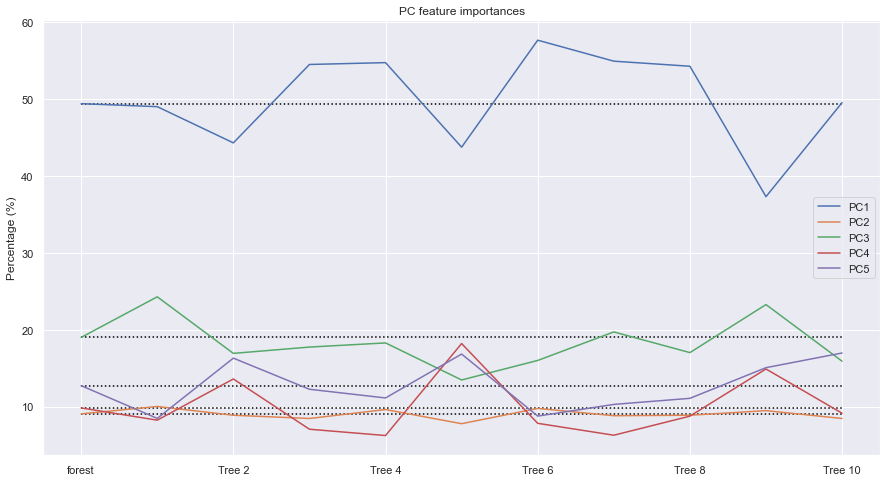

In [40]:
import random

random.seed(random_state)

sample_size = 10
forest_trees = forest_search.best_estimator_.estimators_
trees_sample = random.sample(forest_trees, sample_size)

forest_importances = {f'PC{index+1}': [np.round(100*importance,2)] for index, importance in enumerate(forest_search.best_estimator_.feature_importances_)}
forest_indexes = ['forest']

for tree_index, tree in enumerate(trees_sample):
    for importance_index, importance in enumerate(tree.feature_importances_):
        forest_importances[f'PC{importance_index+1}'].append(np.round(100*importance,2))
    forest_indexes.append(f'Tree {tree_index+1}')

pd.DataFrame(forest_importances, index=forest_indexes).plot(figsize=(15,8))
plt.legend(loc='best');
plt.ylabel('Percentage (%)')
plt.title('PC feature importances')

for index in np.arange(len(forest_search.best_estimator_.feature_importances_)):
    plt.hlines(y=100*forest_search.best_estimator_.feature_importances_[index],
               colors='black',
               linestyles='dotted',
               xmin=0,
               xmax=sample_size)

plt.show()

Trazando líneas horizantales para cada componente principal en el valor de importancia para el bosque, podríamos interpretar o intuir que la importancia de una feature del bosque podría ser una clase de promedio de las importancias de cada árbol que lo compone.

Se aprecia que la primara componente principal domina sobre el resto. Veamos la relación entre este componente y los campos originales.

In [41]:
def study_principal_component(pc_index, features=original_X_test.columns):
    pd.DataFrame(pca.components_[pc_index,:], index=features, columns=['Coefficient']).plot.bar(figsize=(18,5), rot=0)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Importances vs Features')
    plt.show()

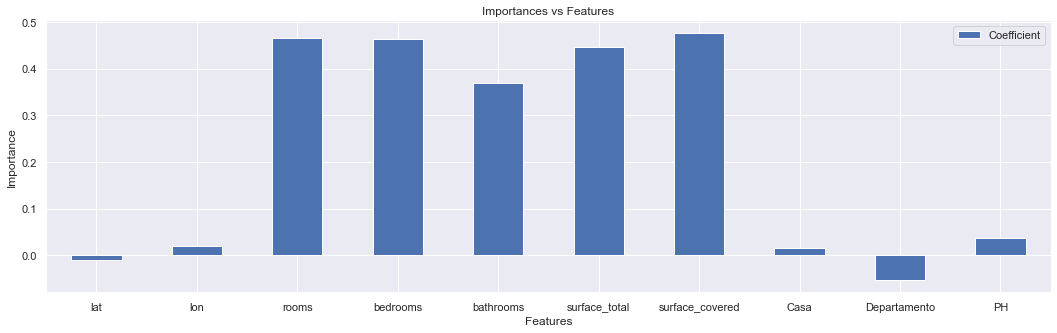

In [42]:
study_principal_component(0)

Vemos una separación muy marcada: elementos con coeficientes mayores a 0.36 y elementos menores a 0.06 (en valor absoluto).

En comparación de ordenes de magnitud podríamos considerar como despreciable la influencia del segundo grupo mencionado. Por ello, eliminandolos, quedamos con: habitaciones, ambientes, banos y ambos tipos de superficie. Podemos así concluir de este punto que el primer componente principal contempla los campos relacionados con el tamaño del inmueble.

Seguimos el mismo proceso con el segundo componente y tendremos:

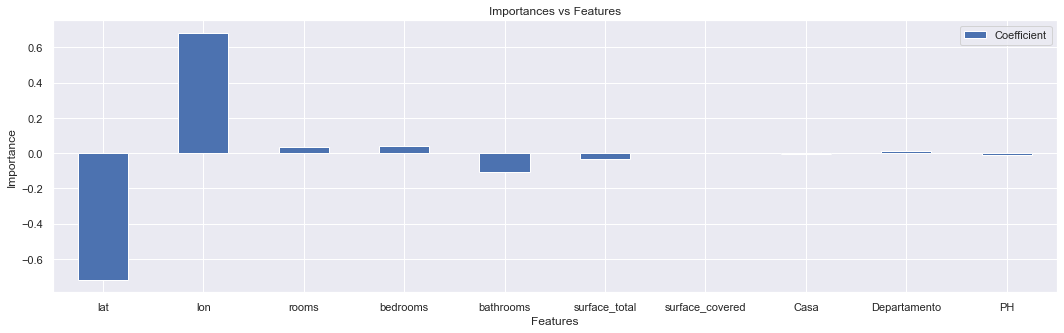

In [43]:
study_principal_component(1)

El segundo componente principal engloba la influencia (o contribución) de la ubicación del inmueble.

En ambos casos, que los componentes principales sean en primer lugar el tamaño y luego la ubicación, son resultados esperados en los datos.

### Interpretación de errores

En este punto usaremos las etiquetas que guardamos en el proceso de separación de train/test.
Haremos un análisis de residuos donde mostraremos los resultados clasificados por barrio y por tipo de propiedad.

In [44]:
def plot_residuals(y, residuals, labels, legend=True):
    plt.figure(figsize=(15,5))
    sns.scatterplot(x=y/1000, y=residuals/1000, hue=labels, legend=legend)
    plt.xlabel('Price (kUSD)')
    plt.ylabel('Residual (kUSD)')
    plt.title('Residuals vs Prices')
    plt.show()

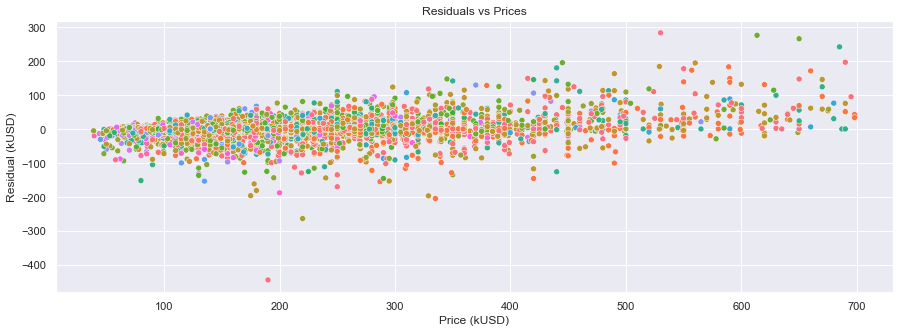

In [45]:
residuals = y_test - y_test_pred
plot_residuals(y=y_test, residuals=residuals, labels=X_test_labels.l3, legend=False)

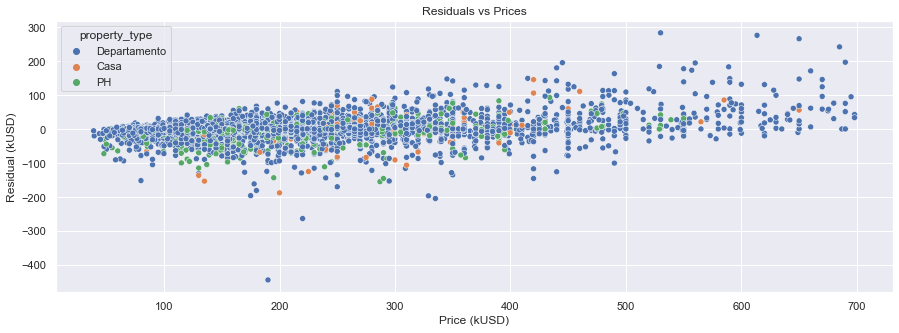

In [46]:
plot_residuals(y=y_test, residuals=residuals, labels=X_test_labels.property_type)

De ambos gráficos podemos sacar las siguentes conclusiones:

* Para valores altos de precios de inmuebles, el modelo sub-estima el precio. El caso opuesto ocurre igualmente, para precios bajos, el modelo sobre-estima el valor.
* Para el primer gráfico, no podemos sacar alguna conclusion del efecto del barrio sobre los errores.
* Con el segundo gráfico, vemos que los inmuebles con mayores errores son departamentos. Esto podría indicar que poseen características especiales que no están siendo consideradas. Probablemente exista la necesidad de incluir algún campo nuevo que por los momentos se desconoce.

Veamos brevemente las características de los inmuebles con mayores errores. Para ello, definimos la siguiente función:

In [47]:
def get_instances_by_residuals(dataset, test_set, residuals, threshold):
    invalid_indexes = test_set[(np.abs(residuals) > threshold)].index
    return dataset.iloc[invalid_indexes][['property_type', 'l3', 'price', 'rooms', 'bedrooms', 'bathrooms', 'surface_covered', 'surface_total']]

En primer lugar, veamos el inmueble con mayor error:

In [48]:
get_instances_by_residuals(dataset, original_X_test, residuals, threshold=400000)

,property_type,l3,price,rooms,bedrooms,bathrooms,surface_covered,surface_total
21605,Departamento,Belgrano,190000.0,4.0,3.0,3.0,148.0,156.0


Debido a la zona, Belgrano, que conocemos que es uno de los barrios que podrían considerarse como costosos y la cantidad de baños y habitaciones, existe la posibilidad que ese no sea el precio real. El modelo predice un precio de al menos 400k más alto.

Revisando los inmuebles con más de 200k USD de error:

In [49]:
get_instances_by_residuals(dataset, original_X_test, residuals, threshold=200000)

,property_type,l3,price,rooms,bedrooms,bathrooms,surface_covered,surface_total
33750,Departamento,Caballito,650000.0,4.0,3.0,2.0,130.0,160.0
36515,Departamento,Puerto Madero,685000.0,3.0,2.0,2.0,120.0,127.0
43373,Departamento,Barrio Norte,530000.0,2.0,1.0,1.0,60.0,70.0
25984,Departamento,Recoleta,335000.0,4.0,3.0,3.0,147.0,168.0
46439,Departamento,Caballito,613567.0,4.0,3.0,2.0,120.0,128.0
21605,Departamento,Belgrano,190000.0,4.0,3.0,3.0,148.0,156.0
5581,Departamento,Balvanera,220000.0,5.0,3.0,3.0,186.0,200.0


Las características de los inmuebles pueden indicarnos una de dos cosas:

1. Hay alguna otra variable a considerar para el modelo que desconocemos.
1. Hay un error en estos datos.

### Conclusiones

* Luego de aplicar técnicas avanzadas para la limpieza y mejora de la calidad de los datos, el desempeño del modelo usado en el proyecto 1, Decision Tree, aumentó al doble (el error disminuyó a la mitad).
* El modelo con mejor desempeño fue el Random Forest.
* El mejor error conseguido es cercano a los 30k USD.
* Para la predicción de los precios de inmuebles, el tamaño es el principal factor a considerar y luego la ubicacion (resultado esperado del dataset).
* Existen indicios que nuevos atributos sean necesarios para mejorar los resultados del análisis.

### Puntos a mejorar

* Utilizar alguna estrategia para obtener información de los campos de descripción podría ayudar a encontrar nuevas variables relevantes para el modelo.
* Incluir los datos de los inmuebles fuera de Capital Federal al análisis.
* Usar otros modelos como `XGBoost` para generar predicciones y comparar desempeños.
* Dentro de Capital Federal pueden existir zonas donde los inmuebles tengan un comportamiento similar (posible aplicación práctica una técnica de clustering). Por ello, tener varios modelos en Capital Federal pueden mejorar los resultados de las predicciones.
* Usar técnicas de imputación de valores y comparar desempeños.

### Proyecto 4

